# Exploration des occupations et de leur évolution dans le temps 

Dans ce carnet est proposée une exploration des occupations de la population Wikidata retenue.

On essayera de prendre connaissance des liens entre types d'occupation, le genre et les générations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


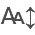

In [2]:
### https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)


In [3]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [4]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


## Explorer les occupations

In [5]:
cn = sql.connect('../../data/astronomers_import.db')

In [6]:
### Le nombre de métiers différents: noter qu'il y des répétitions
## et inconsistances dans les données de Wikidata

q="""
SELECT COUNT(*)
FROM wdt_occupation
"""
cur = cn.cursor()
r = cur.execute(q).fetchone()
print('Nombre de métiers différents:' , r[0])

Nombre de métiers différents: 1246


In [7]:
### Inspecter la table des métiers Wikidata

q="""
SELECT pk_wdt_occupation, label, wdt_uri
FROM wdt_occupation
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[(1, 'astrologer', 'http://www.wikidata.org/entity/Q155647'),
 (2, 'mathematician', 'http://www.wikidata.org/entity/Q170790'),
 (3, 'university teacher', 'http://www.wikidata.org/entity/Q1622272')]

In [8]:
### Compter les occurrences de chaque métier

q="""
-- noter que la fonction TRIM élimine les éventuels espaces en début ou fin de chaine de charactères
-- la fonction LOWER met tout au minuscule
SELECT TRIM(occupationUri) as occupationUri, LOWER(TRIM(occupationLabel)) AS occupationLabel, COUNT(*) as effectif
FROM wdt_person_occupation
GROUP BY TRIM(occupationUri), LOWER(TRIM(occupationLabel))
ORDER BY effectif DESC
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
rdf = pd.DataFrame(r,columns=['uri', 'label', 'freq'])
rdf.head()

uri               label   freq
0   http://www.wikidata.org/entity/Q169470           physicist  25564
1    http://www.wikidata.org/entity/Q11063          astronomer   8054
2  http://www.wikidata.org/entity/Q1622272  university teacher   7423
3   http://www.wikidata.org/entity/Q170790       mathematician   2888
4    http://www.wikidata.org/entity/Q36180              writer   1122

In [9]:
rdf.tail()

uri                 label  freq
1241  http://www.wikidata.org/entity/Q98544732  scientific collector     1
1242  http://www.wikidata.org/entity/Q98594162      moral theologian     1
1243  http://www.wikidata.org/entity/Q98668847             geohasher     1
1244  http://www.wikidata.org/entity/Q99761949           anti-racist     1
1245    http://www.wikidata.org/entity/Q998628           illuminator     1

In [10]:
### On observe une très grande dispersion: comment traiter ce problème?

rdf['freq'].describe()

count     1246.000000
mean        54.243178
std        795.884625
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      25564.000000
Name: freq, dtype: float64

In [11]:
### On transforme en DataFrame le résultat du regroupement par fréquence:
# combien de fois un certain nombre d'occurrences ? 

q="""
WITH tw1 AS (
SELECT LOWER(TRIM(occupationLabel)) occupationLabel, COUNT(*) as effectif
FROM wdt_person_occupation
GROUP BY TRIM(occupationUri), LOWER(TRIM(occupationLabel)) )
SELECT effectif, count(*) as nombre_occ, group_concat(occupationLabel, '; ')
FROM tw1
GROUP BY effectif
ORDER BY nombre_occ DESC, effectif ASC;
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()

## La colonne 'occurrences' indique le nombre de mentions d'un métier,
# la colonne'nombre_occ' combien de métiers ont cette occurrence
dfr = pd.DataFrame(r, columns=['occurrences','nombre_occ', 'labels_occ'])

# Par exemple, la première ligne indique qu'il y a 573 métiers mentionnées une seule fois
dfr.head()

occurrences  nombre_occ                                         labels_occ
0            1         573  buddhologist; science teacher; knight; physica...
1            2         172  crime fiction writer; tour guide; chemistry te...
2            3          81  civil rights advocate; computer engineer; muse...
3            4          60  applied mathematician; bibliographer; electron...
4            6          33  television actor; historian of astronomy; holo...

In [12]:
### Les métiers les plus fréquents
dfr.tail()

occurrences  nombre_occ          labels_occ
106         1122           1              writer
107         2888           1       mathematician
108         7423           1  university teacher
109         8054           1          astronomer
110        25564           1           physicist

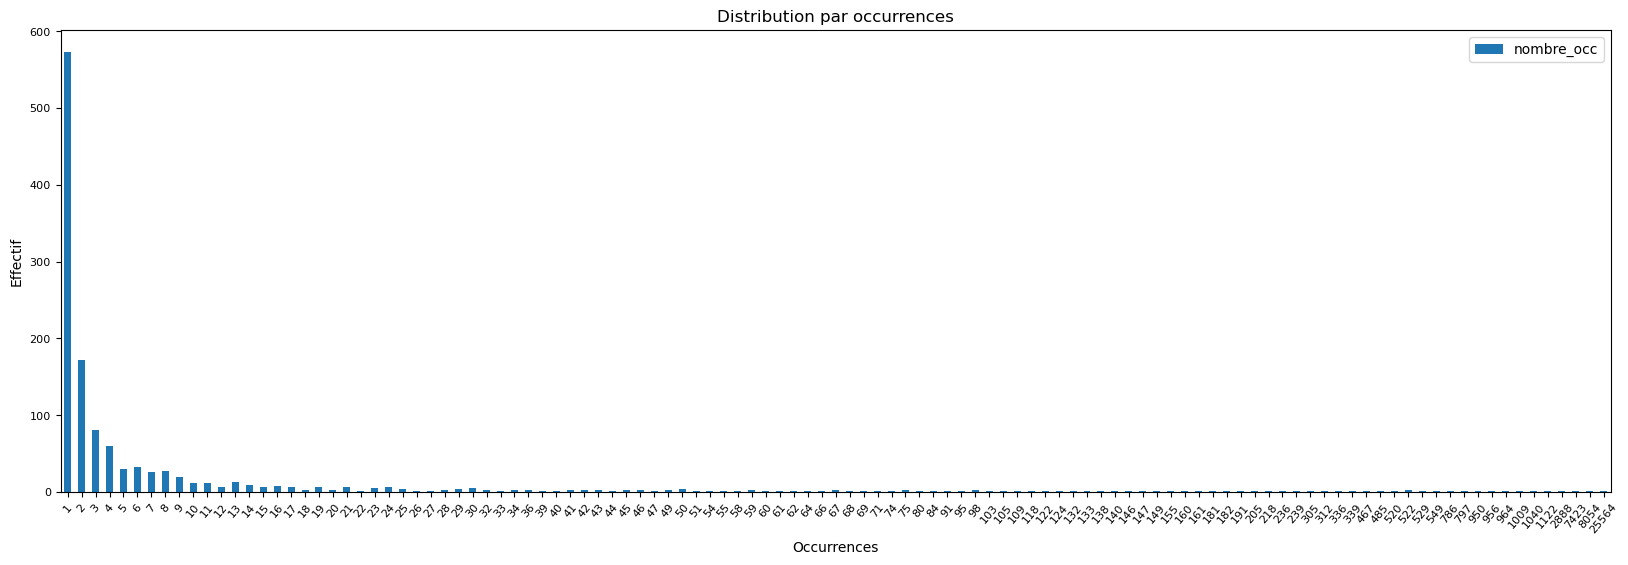

In [13]:
### Représentation graphique des effectifs par occurrences

ax = dfr.sort_values(by='occurrences', ascending=True).plot(x='occurrences', y='nombre_occ', 
                 kind='bar', fontsize=8, figsize=(20,6), rot=50) # ,rot=5


plt.ylabel('Effectif')
plt.xlabel('Occurrences')
plt.title('Distribution par occurrences')
plt.show()

In [14]:
dfr['occ_qcut'] = pd.qcut(dfr['occurrences'], 10)
dfr['occ_qcut']  = dfr['occ_qcut'] .apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)))

dfr.head()

occurrences  nombre_occ                                         labels_occ  \
0            1         573  buddhologist; science teacher; knight; physica...   
1            2         172  crime fiction writer; tour guide; chemistry te...   
2            3          81  civil rights advocate; computer engineer; muse...   
3            4          60  applied mathematician; bibliographer; electron...   
4            6          33  television actor; historian of astronomy; holo...   

  occ_qcut  
0     0-12  
1     0-12  
2     0-12  
3     0-12  
4     0-12

In [15]:
dfrg = dfr.groupby(by='occ_qcut', observed=True).sum(['occurrences','nombre_occ'])
dfrg

occurrences  nombre_occ
occ_qcut                          
0-12                78        1053
12-23              198          67
23-36              324          32
36-50              486          21
50-67              657          14
67-103             908          14
103-147           1414          11
147-239           2077          11
239-786           5150          12
786-25564        50767          11

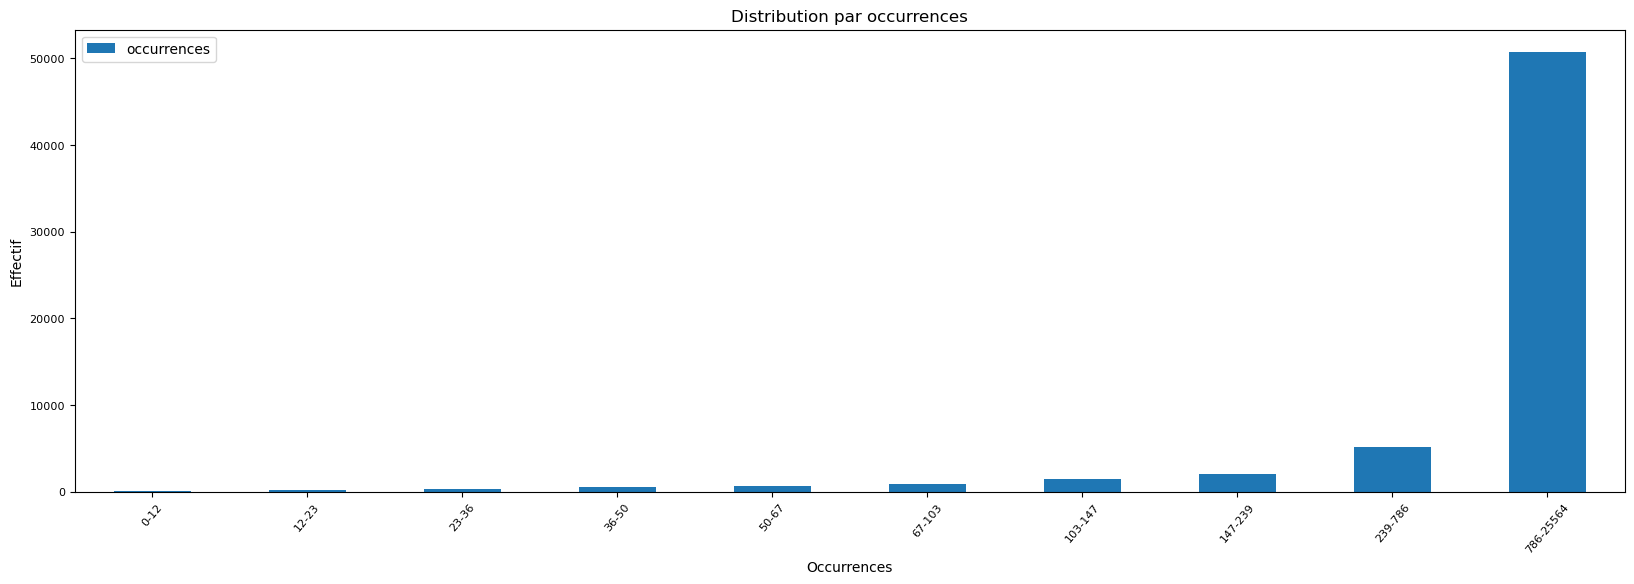

In [16]:
### Représentation graphique des effectifs par occurrences

ax = dfrg.sort_values(by='occurrences', ascending=True).plot( y='occurrences', 
                 kind='bar', fontsize=8, figsize=(20,6), rot=50) # ,rot=5


plt.ylabel('Effectif')
plt.xlabel('Occurrences')
plt.title('Distribution par occurrences')
plt.show()

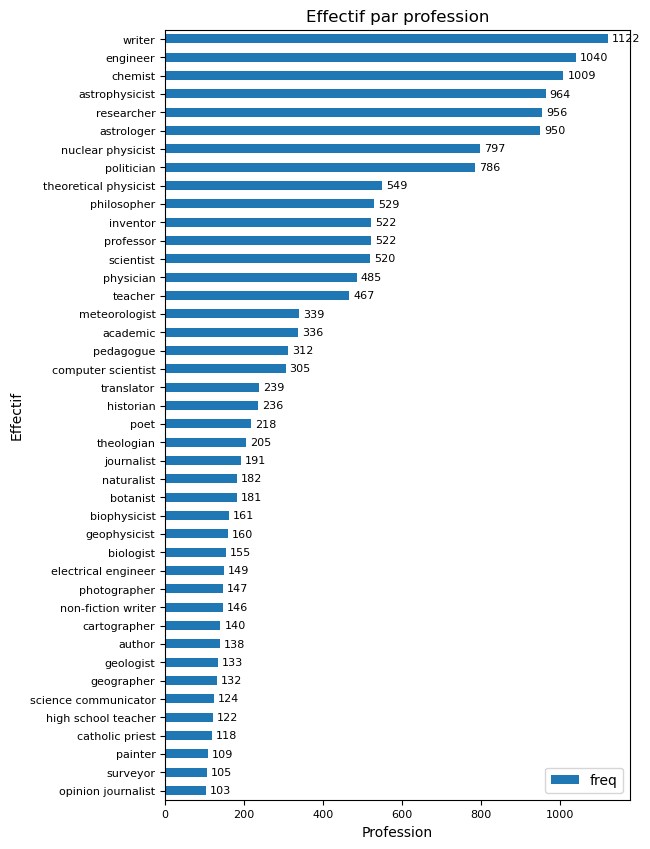

In [17]:
### Représentation graphique des effectifs par profession

# ATTENTION : noter les filtres sur les effectifs
ax = rdf[(rdf['freq']>100) & (rdf['freq'] < 2000)].sort_values(by='freq', ascending=True).plot(x='label', y='freq', 
                 kind='barh', fontsize=8, figsize=(6, 10)) # ,rot=5


#max_xticks = 20
#xloc = plt.MaxNLocator(max_xticks)
#ax.xaxis.set_major_locator(xloc)

x = rdf[(rdf['freq']>100) & (rdf['freq'] < 2000)]['freq'].sort_values(ascending=True).to_list()
for i, v in enumerate(x):
    ax.text(v + 10, i, str(v), color='black', fontsize=8, verticalalignment='center')


plt.ylabel('Effectif')
plt.xlabel('Profession')
plt.title('Effectif par profession')
plt.show()

## Explorer les personnes en relation avec leurs métiers

In [18]:
### Créer la requête SQL et inspecter le résultat
# Noter les jointures entre les différentes tables

q="""
SELECT wp.personUri, wp.personLabel, min(wp.genderUri) gender, 
			min(wp.birthYear) birthYear, 
			group_concat(distinct trim(occupationLabel) order by occupationLabel) occupationLabels
FROM wdt_person_occupation wpo, wdt_personne wp 
WHERE wp.personUri = wpo.personUri 
GROUP BY wp.personUri, wp.personLabel;
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[('http://www.wikidata.org/entity/Q1000193',
  'Hans Elsässer',
  'http://www.wikidata.org/entity/Q6581097',
  '1929',
  'astronomer'),
 ('http://www.wikidata.org/entity/Q1000934',
  'Charles Christian Lauritsen',
  'http://www.wikidata.org/entity/Q6581097',
  '1892',
  'nuclear physicist,physicist,university teacher'),
 ('http://www.wikidata.org/entity/Q100153910',
  'Frank J. Blatt',
  'http://www.wikidata.org/entity/Q6581097',
  '1924',
  'physicist,university teacher')]

### Créer le tableau à analyser

In [19]:
### On transforme la liste en DataFrame

df_p = pd.DataFrame(r, columns=['person_uri', 'person_label', 
                        'genderUri', 'birthYear', 'occupations'])
df_p = df_p.set_index('person_uri',drop=True)



### On ajoute une nouvelle colonne avec les métiers sous forme de liste
df_p['l_occupations'] = df_p.apply(lambda x: x['occupations'].split(','), axis=1)

### On ajoute une nouvelle colonne avec le nombre de composantes de la liste
df_p['length_l_occ'] = df_p.apply(lambda x: len(x['l_occupations']), axis=1)

## on pourrait éliminer la colonne originale
# mais on la laisse car utile pour les filtres
## df_p = df_p.drop(columns=['occupations'])

df_p.head()

person_label  \
person_uri                                                               
http://www.wikidata.org/entity/Q1000193                  Hans Elsässer   
http://www.wikidata.org/entity/Q1000934    Charles Christian Lauritsen   
http://www.wikidata.org/entity/Q100153910               Frank J. Blatt   
http://www.wikidata.org/entity/Q100155322               Edgar Knobloch   
http://www.wikidata.org/entity/Q100157315                    Ding Jing   

                                                                         genderUri  \
person_uri                                                                           
http://www.wikidata.org/entity/Q1000193    http://www.wikidata.org/entity/Q6581097   
http://www.wikidata.org/entity/Q1000934    http://www.wikidata.org/entity/Q6581097   
http://www.wikidata.org/entity/Q100153910  http://www.wikidata.org/entity/Q6581097   
http://www.wikidata.org/entity/Q100155322  http://www.wikidata.org/entity/Q6581097   
http://www.wikidata.org/entity/Q100157315  http://www.wikidata.org/entity/Q6581097   

                                          birthYear  \
person_uri                                            
http://www.wikidata.org/entity/Q1000193        1929   
http://www.wikidata.org/entity/Q1000934        1892   
http://www.wikidata.org/entity/Q100153910      1924   
http://www.wikidata.org/entity/Q100155322      1953   
http://www.wikidata.org/entity/Q100157315      1924   

                                                                              occupations  \
person_uri                                                                                  
http://www.wikidata.org/entity/Q1000193                                        astronomer   
http://www.wikidata.org/entity/Q1000934    nuclear physicist,physicist,university teacher   
http://www.wikidata.org/entity/Q100153910                    physicist,university teacher   
http://www.wikidata.org/entity/Q100155322                                       physicist   
http://www.wikidata.org/entity/Q100157315                    physicist,university teacher   

                                                                               l_occupations  \
person_uri                                                                                     
http://www.wikidata.org/entity/Q1000193                                         [astronomer]   
http://www.wikidata.org/entity/Q1000934    [nuclear physicist, physicist, university teac...   
http://www.wikidata.org/entity/Q100153910                    [physicist, university teacher]   
http://www.wikidata.org/entity/Q100155322                                        [physicist]   
http://www.wikidata.org/entity/Q100157315                    [physicist, university teacher]   

                                           length_l_occ  
person_uri                                               
http://www.wikidata.org/entity/Q1000193               1  
http://www.wikidata.org/entity/Q1000934               3  
http://www.wikidata.org/entity/Q100153910             2  
http://www.wikidata.org/entity/Q100155322             1  
http://www.wikidata.org/entity/Q100157315             2

In [20]:
print(len(df_p))

32908


### Coder le genre

In [21]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'g_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction 
def code_gender(g_uri):
    if g_uri == 'http://www.wikidata.org/entity/Q6581097':
        # genre masculin
        a = 'M'
    elif g_uri =='http://www.wikidata.org/entity/Q6581072':
        # genre féminin
        a = 'F'
    else:
        # genre autre
        a = 'A'
    return a    

In [22]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['gender'] = df_p.apply(lambda x: code_gender(x['genderUri']), axis=1)

## on élimine la colonne originale 
df_p = df_p.drop(columns=['genderUri'])
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['gender']=='A'][:5]

person_label birthYear  \
person_uri                                                                   
http://www.wikidata.org/entity/Q124414761               JA Grier      1968   
http://www.wikidata.org/entity/Q125054679            Zhao Wenjin      1991   
http://www.wikidata.org/entity/Q15990211          Rachael Padman      1954   
http://www.wikidata.org/entity/Q16913156        Ophelia Pastrana      1982   
http://www.wikidata.org/entity/Q23656158   Lucianne M. Walkowicz      1979   

                                                                                 occupations  \
person_uri                                                                                     
http://www.wikidata.org/entity/Q124414761           astronomer,planetary scientist,scientist   
http://www.wikidata.org/entity/Q125054679                                          physicist   
http://www.wikidata.org/entity/Q15990211                 astronomer,astrophysicist,physicist   
http://www.wikidata.org/entity/Q16913156   YouTuber,actor,businessperson,physicist,televi...   
http://www.wikidata.org/entity/Q23656158                                          astronomer   

                                                                               l_occupations  \
person_uri                                                                                     
http://www.wikidata.org/entity/Q124414761       [astronomer, planetary scientist, scientist]   
http://www.wikidata.org/entity/Q125054679                                        [physicist]   
http://www.wikidata.org/entity/Q15990211             [astronomer, astrophysicist, physicist]   
http://www.wikidata.org/entity/Q16913156   [YouTuber, actor, businessperson, physicist, t...   
http://www.wikidata.org/entity/Q23656158                                        [astronomer]   

                                           length_l_occ gender  
person_uri                                                      
http://www.wikidata.org/entity/Q124414761             3      A  
http://www.wikidata.org/entity/Q125054679             1      A  
http://www.wikidata.org/entity/Q15990211              3      A  
http://www.wikidata.org/entity/Q16913156              5      A  
http://www.wikidata.org/entity/Q23656158              1      A

In [23]:
### Effectifs par genre
df_p.groupby(by='gender', observed=True).size()

gender
A       13
F     2789
M    30106
dtype: int64

### Ajouter les périodes

In [24]:
### Préparer les données

# transformer l'année en entier
df_p['birthYear'] = df_p['birthYear'].astype(int)
# limiter aux personnes nées avant le 21e siècle
df_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)
# vérifier année minimale et maximale
print(min(df_p['birthYear']),max(df_p['birthYear']))

1355 2000


In [25]:
### Créer six périodes
l_per = [1351, 1501, 1601, 1701, 1801, 1921, 2001]

In [26]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['periodes'] = pd.cut(df_p['birthYear'], l_per, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periodes'] = df_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

person_label  \
person_uri                                                               
http://www.wikidata.org/entity/Q1000193                  Hans Elsässer   
http://www.wikidata.org/entity/Q1000934    Charles Christian Lauritsen   
http://www.wikidata.org/entity/Q100153910               Frank J. Blatt   

                                           birthYear  \
person_uri                                             
http://www.wikidata.org/entity/Q1000193         1929   
http://www.wikidata.org/entity/Q1000934         1892   
http://www.wikidata.org/entity/Q100153910       1924   

                                                                              occupations  \
person_uri                                                                                  
http://www.wikidata.org/entity/Q1000193                                        astronomer   
http://www.wikidata.org/entity/Q1000934    nuclear physicist,physicist,university teacher   
http://www.wikidata.org/entity/Q100153910                    physicist,university teacher   

                                                                               l_occupations  \
person_uri                                                                                     
http://www.wikidata.org/entity/Q1000193                                         [astronomer]   
http://www.wikidata.org/entity/Q1000934    [nuclear physicist, physicist, university teac...   
http://www.wikidata.org/entity/Q100153910                    [physicist, university teacher]   

                                           length_l_occ gender   periodes  
person_uri                                                                 
http://www.wikidata.org/entity/Q1000193               1      M  1921-2000  
http://www.wikidata.org/entity/Q1000934               3      M  1801-1920  
http://www.wikidata.org/entity/Q100153910             2      M  1921-2000

In [27]:
### Effectifs par période
df_p.groupby(by='periodes', observed=True).size()

periodes
1351-1500      221
1501-1600      476
1601-1700      593
1701-1800     1372
1801-1920     9484
1921-2000    20677
dtype: int64

## Distribution des combinaisons de métiers

In [28]:
df_p.head(2)

person_label  \
person_uri                                                             
http://www.wikidata.org/entity/Q1000193                Hans Elsässer   
http://www.wikidata.org/entity/Q1000934  Charles Christian Lauritsen   

                                         birthYear  \
person_uri                                           
http://www.wikidata.org/entity/Q1000193       1929   
http://www.wikidata.org/entity/Q1000934       1892   

                                                                            occupations  \
person_uri                                                                                
http://www.wikidata.org/entity/Q1000193                                      astronomer   
http://www.wikidata.org/entity/Q1000934  nuclear physicist,physicist,university teacher   

                                                                             l_occupations  \
person_uri                                                                                   
http://www.wikidata.org/entity/Q1000193                                       [astronomer]   
http://www.wikidata.org/entity/Q1000934  [nuclear physicist, physicist, university teac...   

                                         length_l_occ gender   periodes  
person_uri                                                               
http://www.wikidata.org/entity/Q1000193             1      M  1921-2000  
http://www.wikidata.org/entity/Q1000934             3      M  1801-1920

In [29]:
### Compter les effectifs par combinaison de professions
combinaisons = pd.DataFrame(df_p.groupby(by='occupations', observed=True).size()\
                            .sort_values(ascending=False),
                             columns=['effectif'])
combinaisons.reset_index(drop=False, inplace=True)
combinaisons['l_occupations'] = combinaisons.apply(lambda x: x['occupations'].split(','), axis=1)
combinaisons['length_l_occ'] = combinaisons.apply(lambda x: len(x['l_occupations']), axis=1)
combinaisons.head()

occupations  effectif                    l_occupations  \
0                     physicist     11012                      [physicist]   
1                    astronomer      3345                     [astronomer]   
2  physicist,university teacher      3030  [physicist, university teacher]   
3       mathematician,physicist       471       [mathematician, physicist]   
4          physicist,researcher       428          [physicist, researcher]   

   length_l_occ  
0             1  
1             1  
2             2  
3             2  
4             2

In [30]:
combinaisons.sort_values(by='length_l_occ', ascending=False).head()

occupations  effectif  \
5072  aphorist,art critic,art historian,art theorist...         1   
3428  astronomer,botanical collector,botanist,chambe...         1   
2359  Dungeon Master,Magic: The Gathering player,Wik...         1   
5434  anatomist,architect,architectural draftsperson...         1   
4220  archivist,biologist,diplomat,diplomatician,eng...         1   

                                          l_occupations  length_l_occ  
5072  [aphorist, art critic, art historian, art theo...            31  
3428  [astronomer, botanical collector, botanist, ch...            26  
2359  [Dungeon Master, Magic: The Gathering player, ...            23  
5434  [anatomist, architect, architectural draftsper...            23  
4220  [archivist, biologist, diplomat, diplomatician...            21

In [31]:
## Noter que ce sont les trois métiers qui sont à la base de la requête SPARQL

combinaisons[(combinaisons['length_l_occ'] == 1) ] 

occupations  effectif l_occupations  length_l_occ
0    physicist     11012   [physicist]             1
1   astronomer      3345  [astronomer]             1
11  astrologer       262  [astrologer]             1

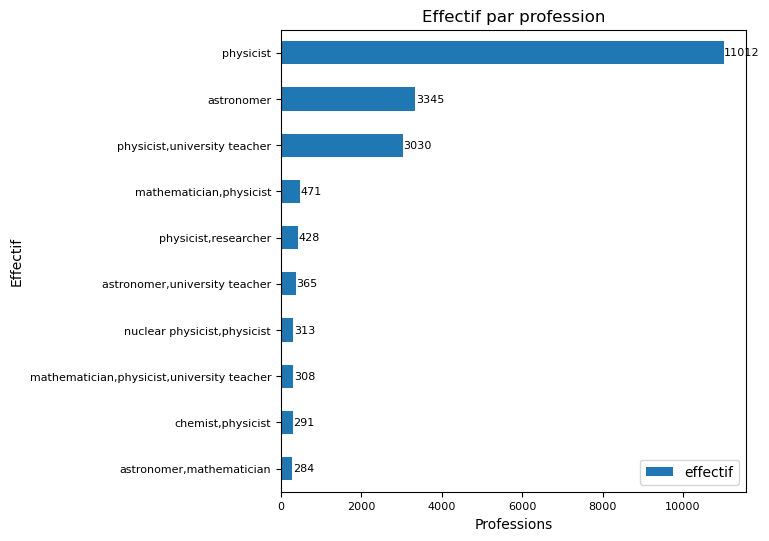

In [32]:
### Représentation graphique des effectifs par profession
# noter la prédominance de certaines modalités

# ATTENTION : noter les filtres sur les effectifs
ax = combinaisons[:10].sort_values(by='effectif', ascending=True).plot(x='occupations', y='effectif', 
                 kind='barh', fontsize=8, figsize=(6, 6)) # ,rot=5
# .sort_values(by='freq', ascending=True)

#max_xticks = 20
#xloc = plt.MaxNLocator(max_xticks)
#ax.xaxis.set_major_locator(xloc)

x = combinaisons[:10].sort_values(by='effectif',ascending=True)['effectif'].to_list()
for i, v in enumerate(x):
    ax.text(v + 10, i, str(v), color='black', fontsize=8, verticalalignment='center')


plt.ylabel('Effectif')
plt.xlabel('Professions')
plt.title('Effectif par profession')
plt.show()

In [33]:
show(combinaisons[['effectif', 'length_l_occ', 'occupations']],  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

In [34]:
c_plus_que_1 = combinaisons[combinaisons['length_l_occ'] > 1]
c_plus_que_1['effectif'].describe()

count    5501.000000
mean        3.309217
std        43.961630
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      3030.000000
Name: effectif, dtype: float64

count    913.000000
mean       4.081051
std        3.308018
min        2.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       19.000000
Name: effectif, dtype: float64


/tmp/ipykernel_31635/141074161.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = c_plus_que_1[(c_plus_que_1['effectif'] > 1) & (combinaisons['effectif'] < 20)]


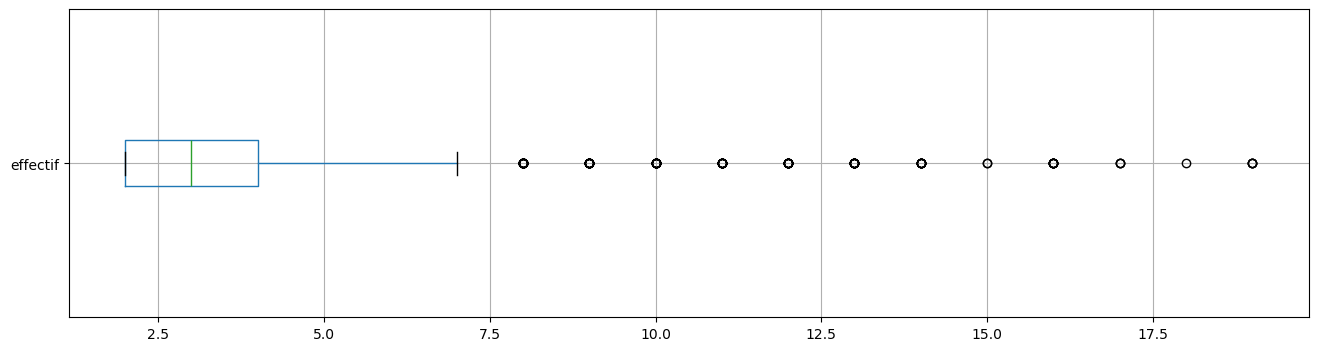

In [35]:
### 
dfc = c_plus_que_1[(c_plus_que_1['effectif'] > 1) & (combinaisons['effectif'] < 20)]
print(dfc['effectif'].describe())

dfc.boxplot(column=['effectif'], vert=False, figsize=(16,4))
plt.show()


count     67.000000
mean     106.447761
std      109.221249
min       21.000000
25%       29.500000
50%       52.000000
75%      145.500000
max      471.000000
Name: effectif, dtype: float64


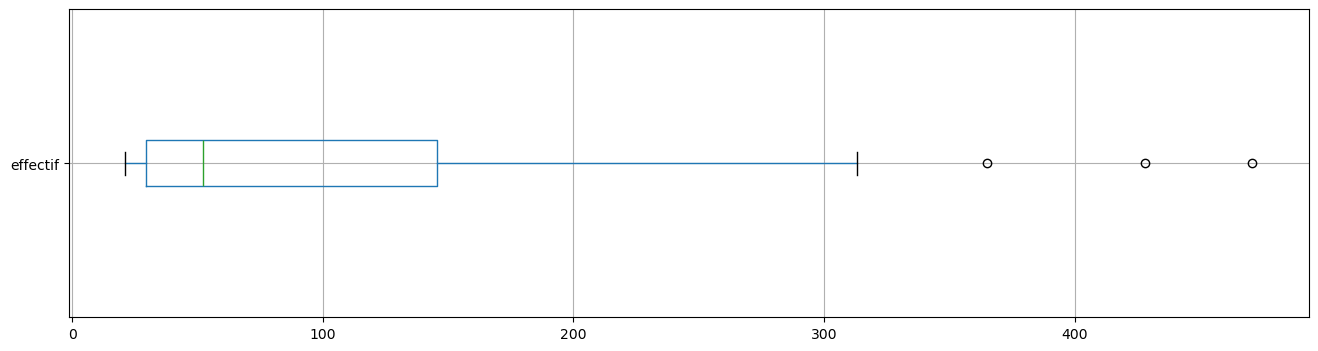

In [36]:
### 

dfc = combinaisons[(combinaisons['effectif'] > 20) & (combinaisons['effectif'] < 1000)]
print(dfc['effectif'].describe())

dfc.boxplot(column=['effectif'], vert=False, figsize=(16,4))
plt.show()


In [37]:
## Compter les effectifs par nombre de composantes
c_eff = combinaisons.groupby(by='length_l_occ').size().sort_values(ascending=False)
c_eff.head()

length_l_occ
3    1671
4    1456
5     804
2     707
6     421
dtype: int64

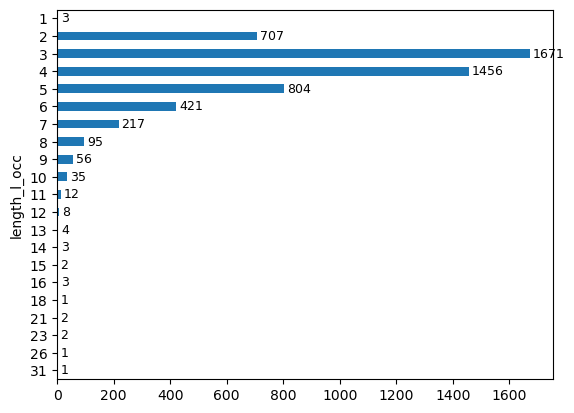

In [38]:
ax = c_eff.sort_index(ascending=False).plot(kind='barh')
x = c_eff.sort_index(ascending=False).to_list()
for i, v in enumerate(x):
    ax.text(v + 10, i, str(v), color='black', fontsize=9, verticalalignment='center')
plt.show()

In [39]:
show(combinaisons[['effectif', 'length_l_occ', 'occupations']][combinaisons['effectif'] < 10], 
    scrollY="300px",
     scrollCollapse=True, paging=False, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

In [40]:
combinaisons[combinaisons['length_l_occ'] == 12]

occupations  effectif  \
1377  academic,astronomer,astrophysicist,cosmologist...         1   
1550  actor,archaeologist,art director,astrologer,co...         1   
2231  Catholic vocation,astronomer,diplomat,geograph...         1   
2500  Catholic bishop,Catholic priest,Christian mini...         1   
3060  Hebraist,Protestant reformer,astronomer,cartog...         1   
3792  astronomer,encyclopédistes,engineer,intellectu...         1   
4010  astrologer,astronomer,cosmologist,mathematicia...         1   
5285  amateur astronomer,astronomer,churchwarden,epi...         1   

                                          l_occupations  length_l_occ  
1377  [academic, astronomer, astrophysicist, cosmolo...            12  
1550  [actor, archaeologist, art director, astrologe...            12  
2231  [Catholic vocation, astronomer, diplomat, geog...            12  
2500  [Catholic bishop, Catholic priest, Christian m...            12  
3060  [Hebraist, Protestant reformer, astronomer, ca...            12  
3792  [astronomer, encyclopédistes, engineer, intell...            12  
4010  [astrologer, astronomer, cosmologist, mathemat...            12  
5285  [amateur astronomer, astronomer, churchwarden,...            12

In [41]:
### Compter les effectifs par combinaison de professions
combinaisons_per = pd.DataFrame(df_p.groupby(by=['occupations','periodes'], observed=True).size()\
                            .sort_values(ascending=False),
                             columns=['effectif'])
combinaisons_per.reset_index(drop=False, inplace=True)
combinaisons_per['l_occupations'] = combinaisons_per.apply(lambda x: x['occupations'].split(','), axis=1)
combinaisons_per['length_l_occ'] = combinaisons_per.apply(lambda x: len(x['l_occupations']), axis=1)
combinaisons_per.head()

occupations   periodes  effectif  \
0                     physicist  1921-2000      8296   
1                     physicist  1801-1920      2587   
2  physicist,university teacher  1921-2000      2214   
3                    astronomer  1921-2000      1764   
4                    astronomer  1801-1920      1240   

                     l_occupations  length_l_occ  
0                      [physicist]             1  
1                      [physicist]             1  
2  [physicist, university teacher]             2  
3                     [astronomer]             1  
4                     [astronomer]             1

In [42]:
tickers = combinaisons_per.groupby(by='periodes', observed=True).size().index.to_list()
tickers

['1351-1500', '1501-1600', '1601-1700', '1701-1800', '1801-1920', '1921-2000']

In [43]:
df = combinaisons_per[combinaisons_per["periodes"] == '1601-1700'].sort_values(by='effectif', ascending=False)[:10][['occupations','effectif']]
df.head() 

occupations  effectif
35                                    astronomer        76
51                      astronomer,mathematician        46
96                                     physicist        18
98                                    astrologer        17
142  astronomer,mathematician,university teacher        11

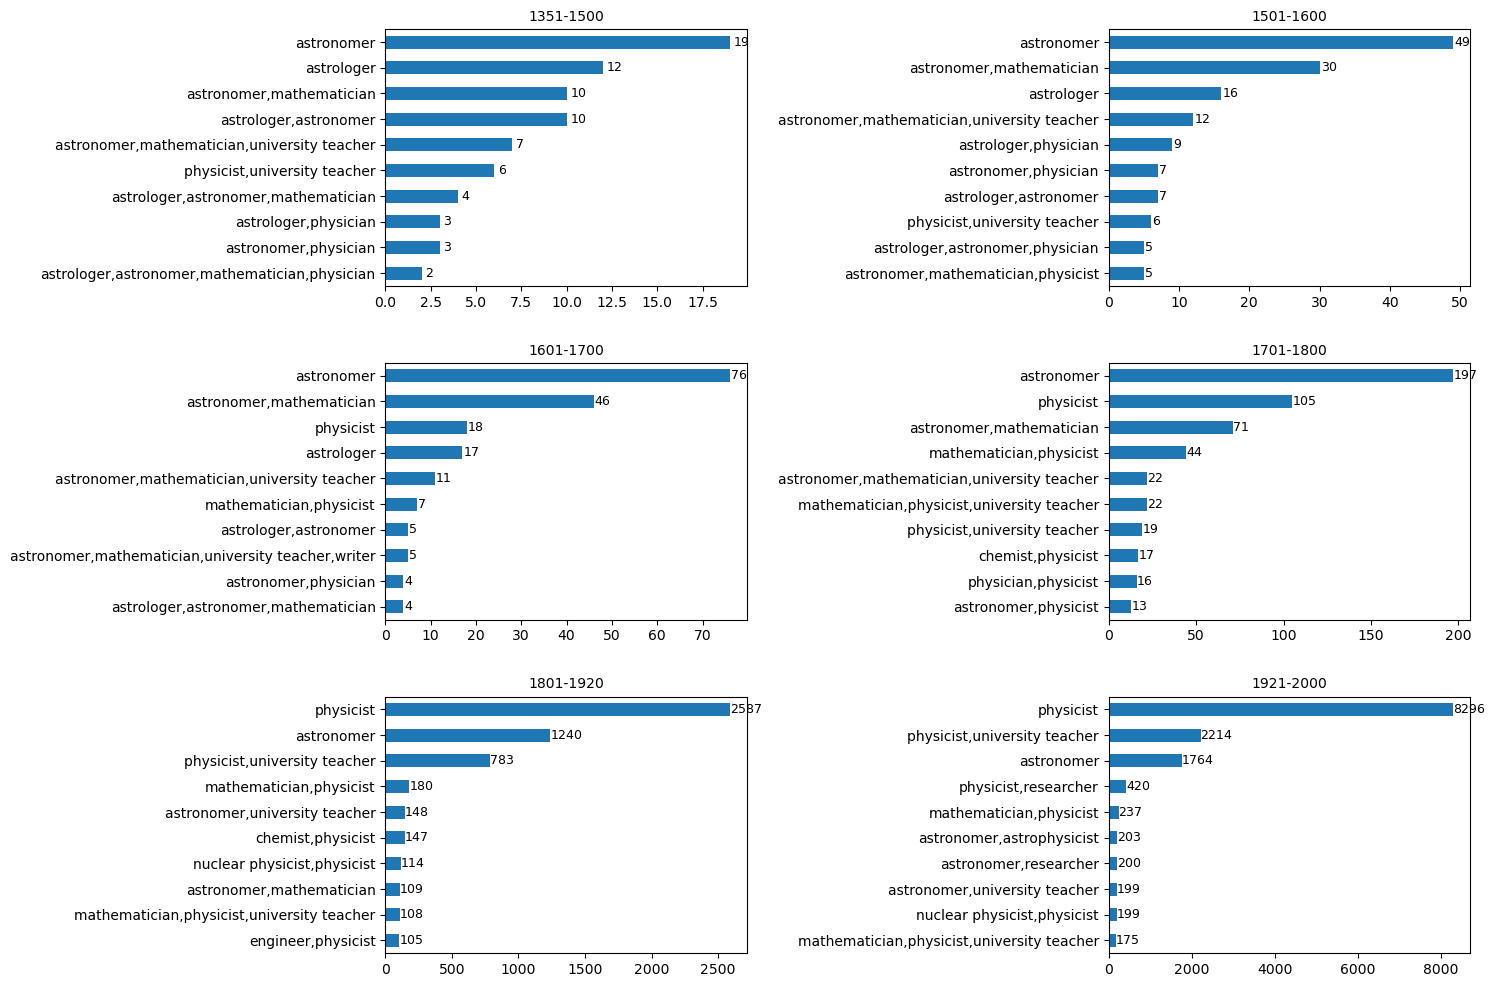

In [44]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(200,100) )
plt.subplots_adjust(hspace=0.3, wspace=1)
#fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop through tickers and axes
for ticker, ax in zip(tickers, axs.ravel()):
    df = combinaisons_per[combinaisons_per["periodes"] == ticker].sort_values(by='effectif', ascending=False)[:10][['occupations','effectif']]


    df.sort_values(by='effectif', ascending=True).plot(ax=ax, x='occupations', y='effectif', 
                    kind='barh', fontsize=10, figsize=(14,12)) # ,rot=5
    # .sort_values(by='freq', ascending=True)

    #max_xticks = 20
    #xloc = plt.MaxNLocator(max_xticks)
    #ax.xaxis.set_major_locator(xloc)

    x = df.sort_values(by='effectif', ascending=True)['effectif'].to_list()
    for i, v in enumerate(x):
        ax.text(v + 0.2, i, str(v), color='black', fontsize=9, verticalalignment='center')


    ax.set_ylabel("")    



    # chart formatting
    ax.set_title(ticker.upper(), fontsize=10)
    ax.get_legend().remove()
    ax.set_xlabel("")

plt.show()


## Market Basket Analysis: la carte Cumulus appliquée aux professions

In [45]:
### Distribution par périodes
gp = df_p[df_p['length_l_occ']> 1].groupby(by=['periodes'], observed=True).size()
gp

periodes
1351-1500      189
1501-1600      406
1601-1700      482
1701-1800     1066
1801-1920     5601
1921-2000    10460
dtype: int64

In [46]:
gp.index.to_list()

['1351-1500', '1501-1600', '1601-1700', '1701-1800', '1801-1920', '1921-2000']

In [47]:
### Esplorer par périodes

# l'ensemble
dd = df_p[df_p['length_l_occ']> 1]

#dd = df_p[(df_p['periodes']=='1501-1600') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1351-1500') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1921-2000') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1801-1920') & (df_p['length_l_occ']> 1)]


In [48]:
te = TransactionEncoder()
## on cherche les combinaisons, on exclut donc les trois disciplines seules
te_ary = te.fit_transform(dd[dd['length_l_occ'] > 1]['l_occupations'])
data_df=pd.DataFrame(te_ary, columns=te.columns_)
# data_df.head()

In [49]:
frequent_itemsets = apriori(data_df, min_support= 0.0099, use_colnames=True)
frequent_itemsets['eff'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
frequent_itemsets['l_itemsets'] = frequent_itemsets['itemsets'].apply(lambda x : sorted(list(x)))
show(frequent_itemsets[['support', 'eff', 'itemsets']].sort_values(by='support', ascending=False), 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)


In [50]:
ar = association_rules(frequent_itemsets, min_threshold=0.0 \
                 ).drop('conviction', axis=1).reset_index(drop=True)

print(len(ar))
ar.sort_values(by='lift', ascending=False).head(10)

154


antecedents  \
2                               (writer)   
3                           (astrologer)   
77               (astronomer, physicist)   
80                      (astrophysicist)   
82      (university teacher, astronomer)   
87                      (astrophysicist)   
83  (university teacher, astrophysicist)   
86                          (astronomer)   
4                           (astronomer)   
5                       (astrophysicist)   

                             consequents  antecedent support  \
2                           (astrologer)            0.060976   
3                               (writer)            0.035542   
77                      (astrophysicist)            0.052900   
80               (astronomer, physicist)            0.052736   
82                      (astrophysicist)            0.069765   
87      (university teacher, astronomer)            0.052736   
83                          (astronomer)            0.019666   
86  (university teacher, astrophysicist)            0.253900   
4                       (astrophysicist)            0.253900   
5                           (astronomer)            0.052736   

    consequent support   support  confidence      lift  leverage  \
2             0.035542  0.010987    0.180180  5.069552  0.008819   
3             0.060976  0.010987    0.309119  5.069552  0.008819   
77            0.052736  0.012690    0.239875  4.548637  0.009900   
80            0.052900  0.012690    0.240625  4.548637  0.009900   
82            0.052736  0.015381    0.220472  4.180709  0.011702   
87            0.069765  0.015381    0.291667  4.180709  0.011702   
83            0.253900  0.015381    0.782123  3.080434  0.010388   
86            0.019666  0.015381    0.060580  3.080434  0.010388   
4             0.052736  0.039936    0.157291  2.982635  0.026547   
5             0.253900  0.039936    0.757292  2.982635  0.026547   

    zhangs_metric  
2        0.854870  
3        0.832326  
77       0.823730  
80       0.823586  
82       0.817864  
87       0.803161  
83       0.688919  
86       0.905201  
4        0.890934  
5        0.701732

In [51]:
show(ar.sort_values(by='lift', ascending=False), 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

In [52]:
show(dd, 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0
       )

## Variation de règles en fonction du temps

In [53]:
combinaisons_per.head()

occupations   periodes  effectif  \
0                     physicist  1921-2000      8296   
1                     physicist  1801-1920      2587   
2  physicist,university teacher  1921-2000      2214   
3                    astronomer  1921-2000      1764   
4                    astronomer  1801-1920      1240   

                     l_occupations  length_l_occ  
0                      [physicist]             1  
1                      [physicist]             1  
2  [physicist, university teacher]             2  
3                     [astronomer]             1  
4                     [astronomer]             1

In [54]:
tickers = combinaisons_per.groupby(by='periodes', observed=True).size().index.to_list()
tickers

['1351-1500', '1501-1600', '1601-1700', '1701-1800', '1801-1920', '1921-2000']

In [55]:
df_p.head(3)

person_label  \
person_uri                                                               
http://www.wikidata.org/entity/Q1000193                  Hans Elsässer   
http://www.wikidata.org/entity/Q1000934    Charles Christian Lauritsen   
http://www.wikidata.org/entity/Q100153910               Frank J. Blatt   

                                           birthYear  \
person_uri                                             
http://www.wikidata.org/entity/Q1000193         1929   
http://www.wikidata.org/entity/Q1000934         1892   
http://www.wikidata.org/entity/Q100153910       1924   

                                                                              occupations  \
person_uri                                                                                  
http://www.wikidata.org/entity/Q1000193                                        astronomer   
http://www.wikidata.org/entity/Q1000934    nuclear physicist,physicist,university teacher   
http://www.wikidata.org/entity/Q100153910                    physicist,university teacher   

                                                                               l_occupations  \
person_uri                                                                                     
http://www.wikidata.org/entity/Q1000193                                         [astronomer]   
http://www.wikidata.org/entity/Q1000934    [nuclear physicist, physicist, university teac...   
http://www.wikidata.org/entity/Q100153910                    [physicist, university teacher]   

                                           length_l_occ gender   periodes  
person_uri                                                                 
http://www.wikidata.org/entity/Q1000193               1      M  1921-2000  
http://www.wikidata.org/entity/Q1000934               3      M  1801-1920  
http://www.wikidata.org/entity/Q100153910             2      M  1921-2000

In [56]:
### Esplorer par périodes

# l'ensemble
dd = df_p[df_p['length_l_occ']> 1]

#dd = df_p[(df_p['periodes']=='1351-1500') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1501-1600') & (df_p['length_l_occ']> 1)]
dd = df_p[(df_p['periodes']=='1601-1700') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1701-1800') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1801-1920') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1921-2000') & (df_p['length_l_occ']> 1)]


In [57]:
te = TransactionEncoder()
## on cherche les combinaisons, on exclut donc les trois disciplines seules
te_ary = te.fit_transform(dd['l_occupations'])
data_df=pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(data_df, min_support= 0.0099, use_colnames=True)
frequent_itemsets['eff'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
frequent_itemsets['l_itemsets'] = frequent_itemsets['itemsets'].apply(lambda x : sorted(list(x)))
frequent_itemsets[['itemsets', 'support']].sort_values(by='support', ascending=False)[:20]

itemsets   support
6                                       (astronomer)  0.639004
24                                   (mathematician)  0.520747
71                       (mathematician, astronomer)  0.390041
38                                       (physicist)  0.387967
48                              (university teacher)  0.213693
131                       (mathematician, physicist)  0.182573
139              (university teacher, mathematician)  0.145228
36                                     (philosopher)  0.132780
163                  (university teacher, physicist)  0.130705
91                  (university teacher, astronomer)  0.122407
49                                          (writer)  0.120332
37                                       (physician)  0.120332
5                                       (astrologer)  0.109959
46                                      (theologian)  0.109959
193  (university teacher, mathematician, astronomer)  0.103734
81                           (astronomer, physicist)  0.087137
148                         (philosopher, physicist)  0.082988
153                           (physician, physicist)  0.082988
219   (university teacher, mathematician, physicist)  0.074689
92                              (writer, astronomer)  0.068465

### Représentation de la variation du *support* à travers le temps

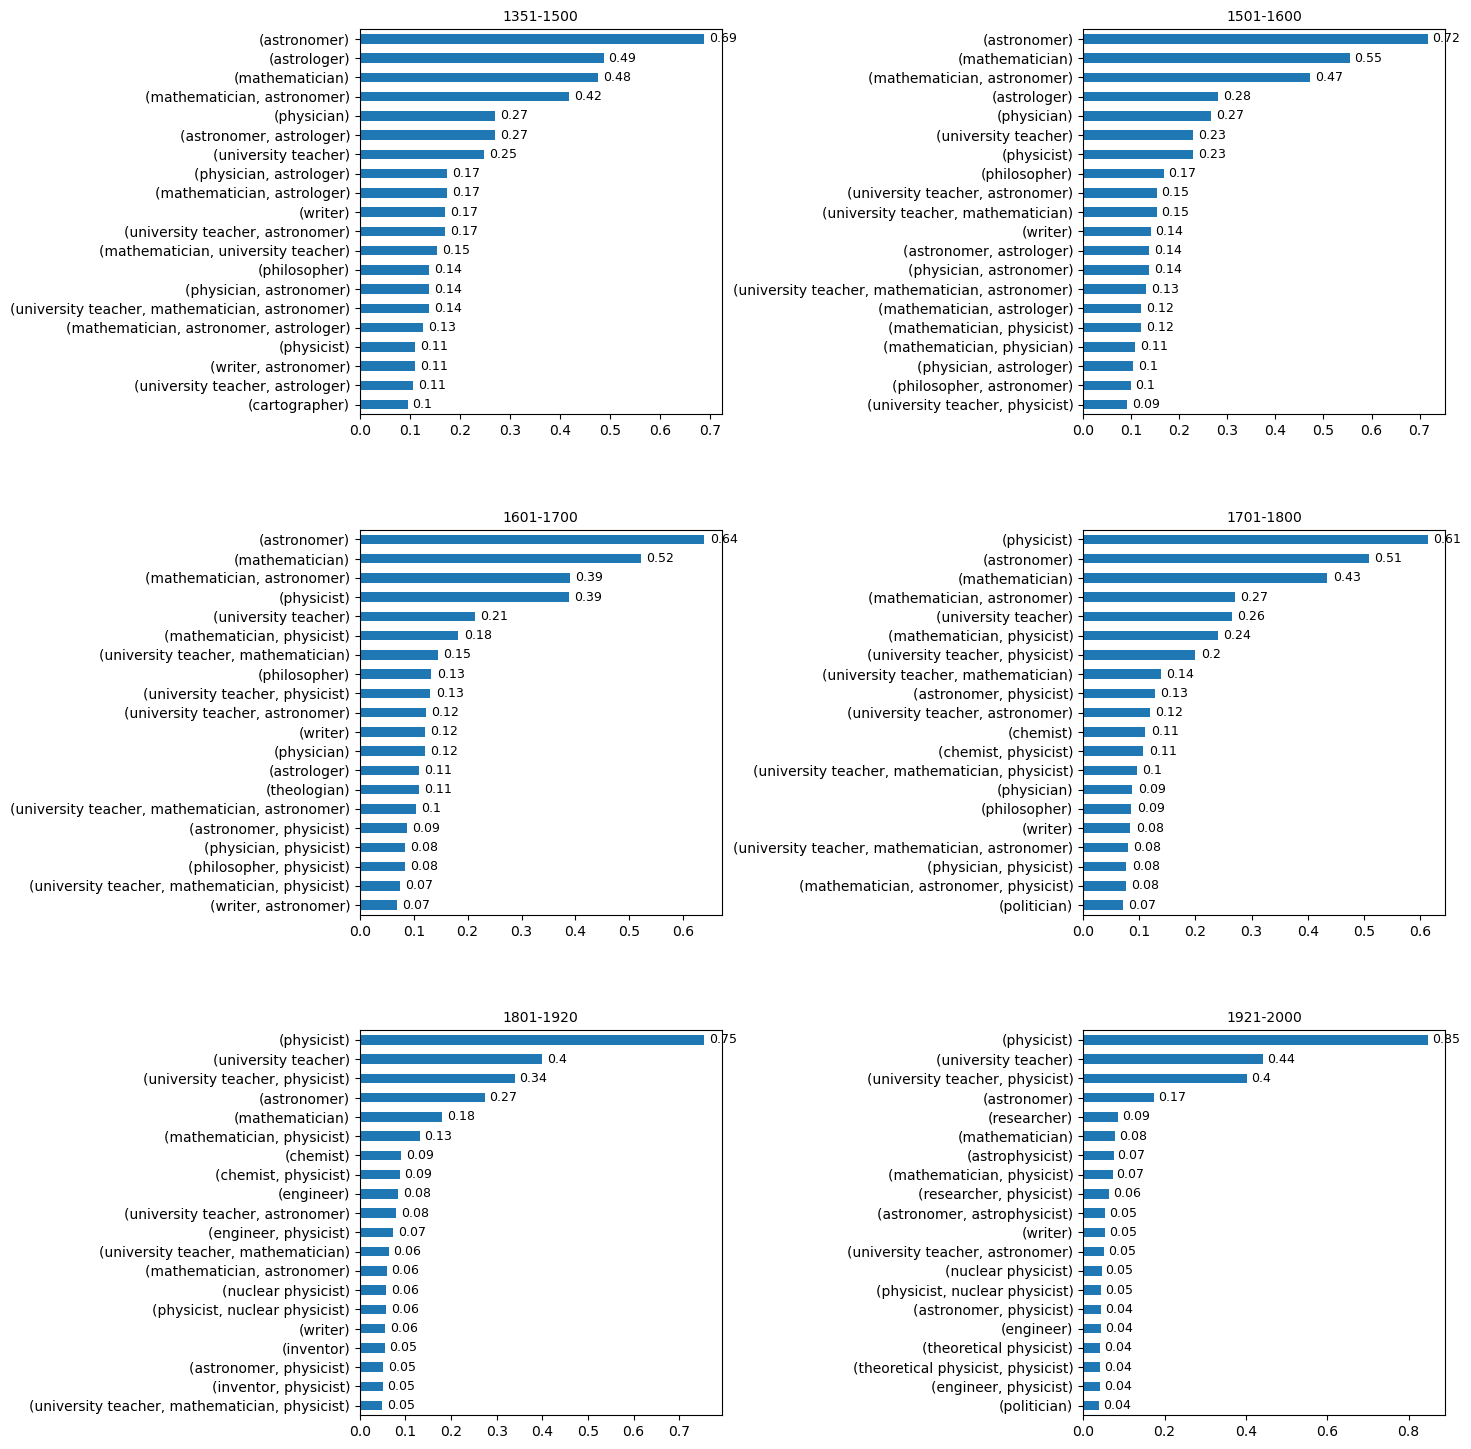

In [58]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(200,100) )
plt.subplots_adjust(hspace=0.3, wspace=1)

# loop through tickers and axes
for ticker, ax in zip(tickers, axs.ravel()):
    dd = df_p[(df_p['periodes']==ticker) & (df_p['length_l_occ']> 1)]
    te = TransactionEncoder()
    ## on cherche les combinaisons, on exclut donc les trois disciplines seules
    te_ary = te.fit_transform(dd['l_occupations'])
    data_df=pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(data_df, min_support= 0.0099, use_colnames=True)
    frequent_itemsets['eff'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
    frequent_itemsets['l_itemsets'] = frequent_itemsets['itemsets'].apply(lambda x : sorted(list(x)))
    df = frequent_itemsets[['itemsets', 'support']].sort_values(by='support', ascending=False)[:20]

    df.sort_values(by='support', ascending=True).plot(ax=ax, x='itemsets', y='support', 
                    kind='barh', fontsize=10, figsize=(14,18)) # ,rot=5
    # .sort_values(by='freq', ascending=True)

    #max_xticks = 20
    #xloc = plt.MaxNLocator(max_xticks)
    #ax.xaxis.set_major_locator(xloc)

    x = df.sort_values(by='support', ascending=True)['support'].to_list()
    for i, v in enumerate(x):
        ax.text(v + 0.01, i, str(round(v,2)), color='black', fontsize=9, verticalalignment='center')


    ax.set_ylabel("")    



    # chart formatting
    ax.set_title(ticker.upper(), fontsize=10)
    ax.get_legend().remove()
    ax.set_xlabel("")

plt.show()


### Représentation du *lift*

In [59]:
### Esplorer par périodes

# l'ensemble
dd = df_p[df_p['length_l_occ']> 1]

#dd = df_p[(df_p['periodes']=='1351-1500') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1501-1600') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1601-1700') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1701-1800') & (df_p['length_l_occ']> 1)]
dd = df_p[(df_p['periodes']=='1801-1920') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1921-2000') & (df_p['length_l_occ']> 1)]


In [60]:
te = TransactionEncoder()
## on cherche les combinaisons, on exclut donc les trois disciplines seules
te_ary = te.fit_transform(dd['l_occupations'])
data_df=pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(data_df, min_support= 0.0099, use_colnames=True)

### On calcule à partir du tableau 'frequent_itemsets' les règles d'association
# deux colonnes ('conviction', 'support') sont supprimées    
ar = association_rules(frequent_itemsets, min_threshold=0.0) \
                 .drop(['conviction', 'support'], axis=1).reset_index(drop=True)

print(len(ar))
cc = ar.sort_values(by='zhangs_metric', ascending=False)
cc['rule'] = cc.apply(lambda x : ','.join(list(x['antecedents'])) + ' -> '+ ','.join(list(x['consequents'])), axis=1 )
cc.head(20)

180


antecedents  \
159                       (physicist)   
54                        (physicist)   
29                        (physicist)   
73                        (physicist)   
143                       (physicist)   
173                       (physicist)   
95                       (astronomer)   
4                        (astronomer)   
119                       (physicist)   
2                            (writer)   
137                       (physicist)   
85            (astronomer, physicist)   
3                        (astrologer)   
25                        (physicist)   
88                   (astrophysicist)   
91   (university teacher, astronomer)   
87                       (astronomer)   
94                   (astrophysicist)   
43                        (physicist)   
167                       (physicist)   

                                     consequents  antecedent support  \
159      (university teacher, nuclear physicist)            0.754865   
54                           (nuclear physicist)            0.754865   
29                         (electrical engineer)            0.754865   
73                       (theoretical physicist)            0.754865   
143               (inventor, university teacher)            0.754865   
173  (theoretical physicist, university teacher)            0.754865   
95          (university teacher, astrophysicist)            0.273880   
4                               (astrophysicist)            0.273880   
119                (university teacher, chemist)            0.754865   
2                                   (astrologer)            0.056061   
137               (engineer, university teacher)            0.754865   
85                              (astrophysicist)            0.051241   
3                                       (writer)            0.022853   
25                                     (chemist)            0.754865   
88                       (astronomer, physicist)            0.031959   
91                              (astrophysicist)            0.079629   
87                   (astrophysicist, physicist)            0.273880   
94              (university teacher, astronomer)            0.031959   
43                                    (inventor)            0.754865   
167             (politician, university teacher)            0.754865   

     consequent support  confidence      lift  leverage  zhangs_metric  \
159            0.028923    0.038316  1.324740  0.007090       1.000000   
54             0.057847    0.076632  1.324740  0.014180       1.000000   
29             0.010534    0.013955  1.324740  0.002582       1.000000   
73             0.018925    0.024834  1.312242  0.004461       0.970672   
143            0.016069    0.021050  1.310020  0.003760       0.965400   
173            0.011069    0.014428  1.303373  0.002535       0.949518   
95             0.014462    0.046284  3.200468  0.008716       0.946876   
4              0.031959    0.101043  3.161687  0.018921       0.941598   
119            0.034280    0.044465  1.297141  0.007689       0.934481   
2              0.022853    0.184713  8.082653  0.009074       0.928321   
137            0.023389    0.030038  1.284290  0.005019       0.903011   
85             0.031959    0.216028  6.759621  0.009432       0.898081   
3              0.056061    0.453125  8.082653  0.009074       0.896772   
25             0.090877    0.116131  1.277892  0.019063       0.887110   
88             0.051241    0.346369  6.759621  0.009432       0.880192   
91             0.031959    0.159193  4.981224  0.010131       0.868395   
87             0.015354    0.040417  2.632288  0.006864       0.853994   
94             0.079629    0.396648  4.981224  0.010131       0.825632   
43             0.054455    0.066935  1.229185  0.009421       0.760613   
167            0.014105    0.017266  1.224127  0.002386       0.746900   

                                                  rule  
159  physicist -> university teacher,nu

### Créer un filtre sur l'antécédent

In [65]:
y = [list(e) for e in cc.antecedents[:1]][0]
y

['physicist']

In [66]:
def filter_antecedents( x, lst = [] ):
    if len(lst) > 0:
        for e in lst:
            # transforme le frozen set en liste
            l = list(x.antecedents)

            if e in l:
                a = True
                break
            else:
                a = False
    else:
        a = True            
    return a           

In [67]:
### Les professions souhaitées
lfp=['non-fiction writer','photographer']
lpf=['astrologer']
lpf=['writer']
#lpf=['physician']

In [69]:
### Dans le tableau précédent, que les antécédents contenant la valeur souhaitée
filtered_cc = cc[cc.apply(lambda x: filter_antecedents(x, lfp), axis=1)]
print(len(filtered_cc))
filtered_cc.head()

0


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, confidence, lift, leverage, zhangs_metric, rule]
Index: []

In [ ]:
show(filtered_cc, 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0
       )

In [ ]:
df_p.head(3)

person_label  \
person_uri                                                               
http://www.wikidata.org/entity/Q1000193                  Hans Elsässer   
http://www.wikidata.org/entity/Q1000934    Charles Christian Lauritsen   
http://www.wikidata.org/entity/Q100153910               Frank J. Blatt   

                                           birthYear  \
person_uri                                             
http://www.wikidata.org/entity/Q1000193         1929   
http://www.wikidata.org/entity/Q1000934         1892   
http://www.wikidata.org/entity/Q100153910       1924   

                                                                              occupations  \
person_uri                                                                                  
http://www.wikidata.org/entity/Q1000193                                        astronomer   
http://www.wikidata.org/entity/Q1000934    nuclear physicist,physicist,university teacher   
http://www.wikidata.org/entity/Q100153910                    physicist,university teacher   

                                                                               l_occupations  \
person_uri                                                                                     
http://www.wikidata.org/entity/Q1000193                                         [astronomer]   
http://www.wikidata.org/entity/Q1000934    [nuclear physicist, physicist, university teac...   
http://www.wikidata.org/entity/Q100153910                    [physicist, university teacher]   

                                           length_l_occ gender   periodes  
person_uri                                                                 
http://www.wikidata.org/entity/Q1000193               1      M  1921-2000  
http://www.wikidata.org/entity/Q1000934               3      M  1801-1920  
http://www.wikidata.org/entity/Q100153910             2      M  1921-2000

## Filtre sur les professions

In [ ]:
### Définition de la fonction de filtre sur le tableau original
def filter_occupation( x, lst = [] ):
    if len(lst) > 0:
        for e in lst:
            if e in x.l_occupations:
                a = True
                break
            else:
                a = False
    else:
        a = True            
    return a           

In [ ]:
### Les professions souhaitées
lpf=['non-fiction writer','photographer']

#lpf=['astrologer','astronomer']
#lpf=['writer']
lpf=['physician']
lpf=[]
lpf=['astrologer']

In [ ]:
### Les professions souhaitées pour les antécédents
lpa=['non-fiction writer','photographer']
lpa=['astrologer']
#lpa=['astrologer','astronomer']
#lpa=['writer']
lpa=['physician']

In [ ]:
filtered_df_p = df_p[df_p.apply(lambda x: filter_occupation(x, lpf), axis=1)]
print('Effectif:', len(filtered_df_p))
try:
      print('Min. birthYear:', min(filtered_df_p.birthYear), '- Max. birthYear:', max(filtered_df_p.birthYear))
except Exception as e:
      print('Pas de valeurs')      

show(filtered_df_p[['periodes','length_l_occ', 'occupations', 
                    'person_label', 'gender', 'birthYear']].sort_values(by='periodes'), 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0
       )

Effectif: 909
Min. birthYear: 1355 - Max. birthYear: 2000


In [ ]:
mt='lift'

te = TransactionEncoder()
## on cherche les combinaisons, on exclut donc les trois disciplines seules
te_ary = te.fit_transform(filtered_df_p['l_occupations'])
data_df=pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(data_df, min_support= 0.009, use_colnames=True)

ar = association_rules(frequent_itemsets, min_threshold=0.0 \
                ).drop(['conviction','support'], axis=1).reset_index(drop=True)
cc = ar.sort_values(by=mt, ascending=False)
cc['rule'] = cc.apply(lambda x : ','.join(list(x['antecedents'])) + ' -> '+ ','.join(list(x['consequents'])), axis=1 )

show(cc, 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0
       )

### Évolution dans le temps

20
20
20
1
5
1


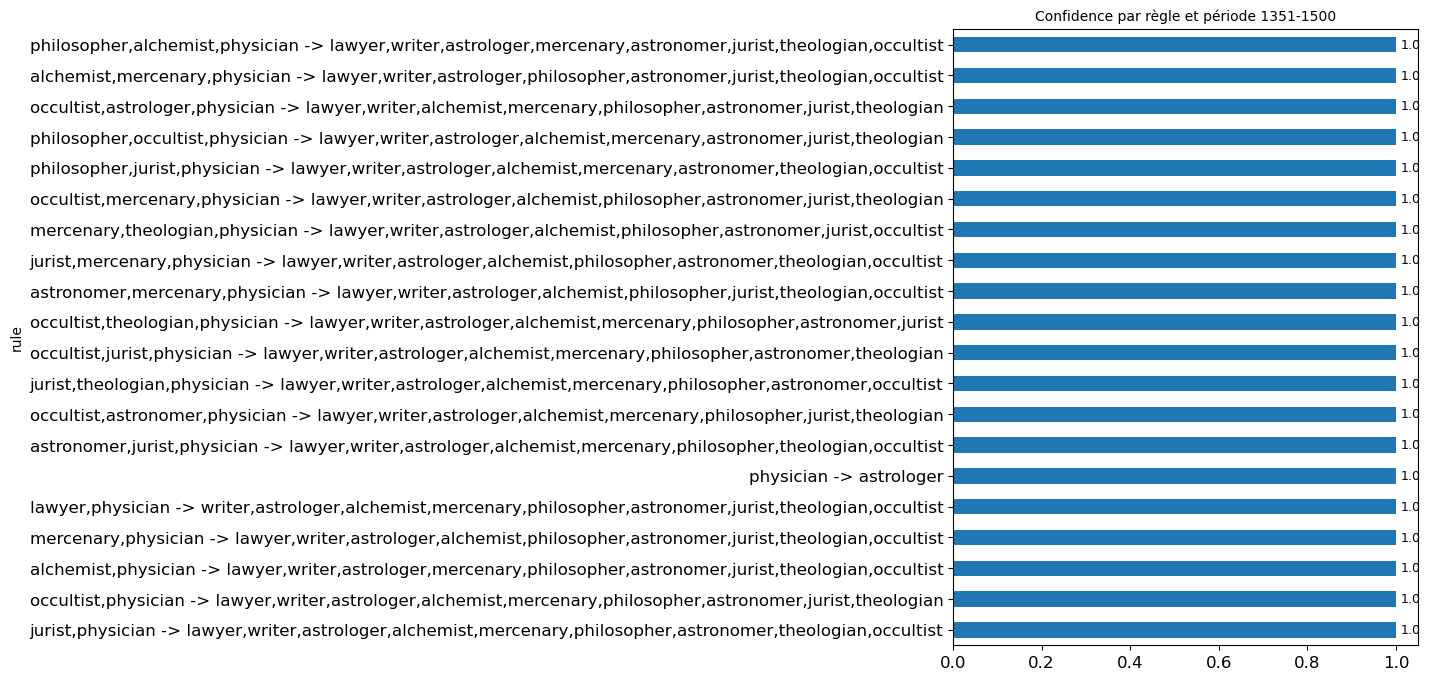

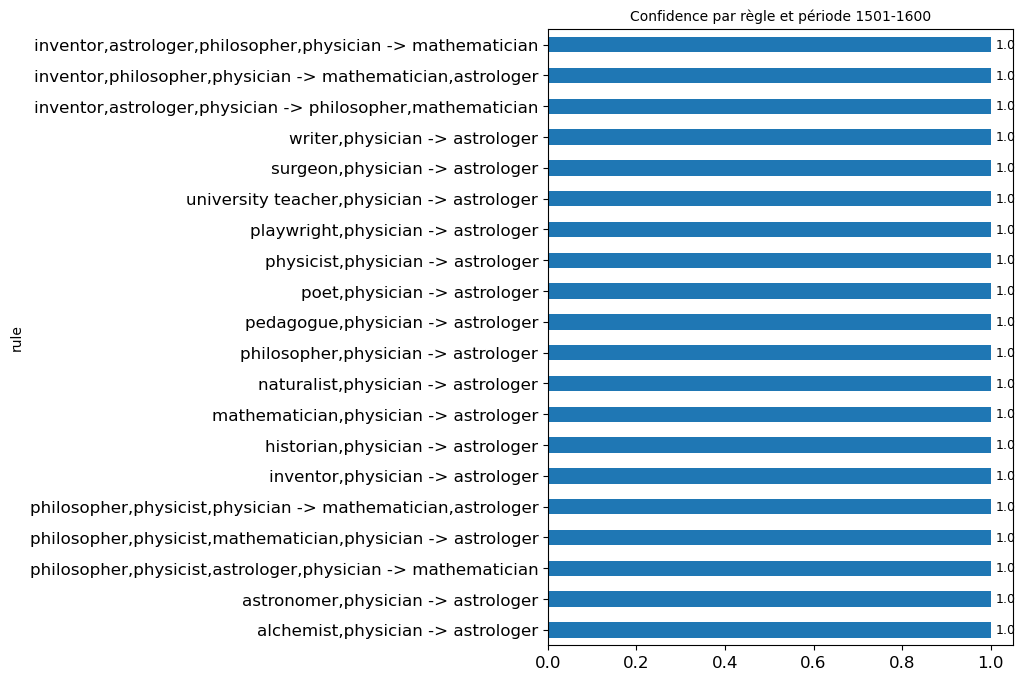

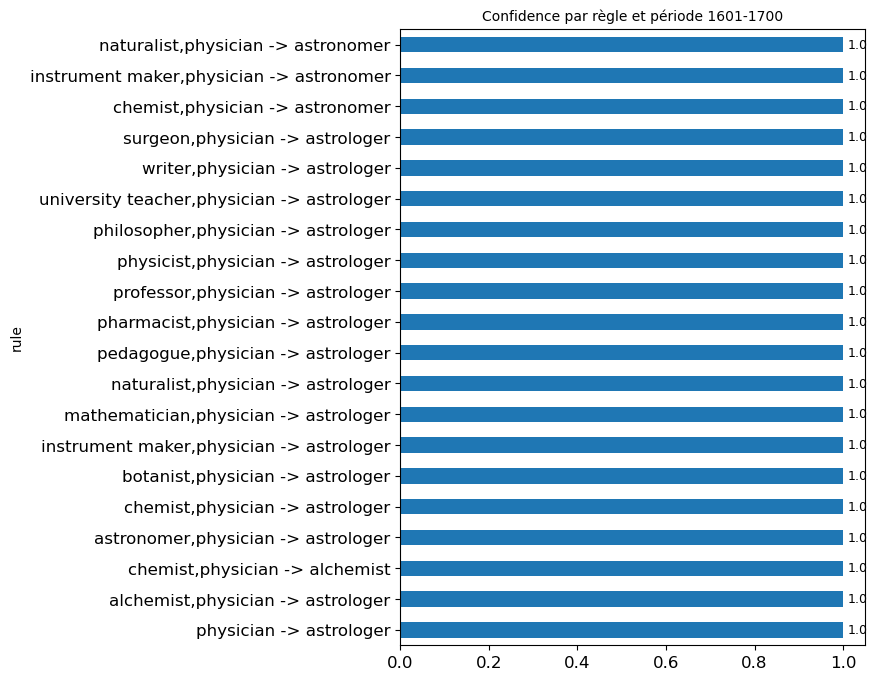

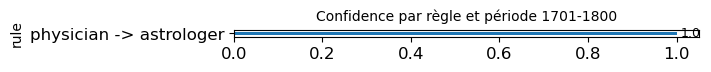

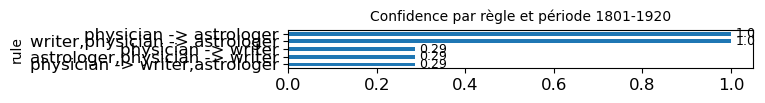

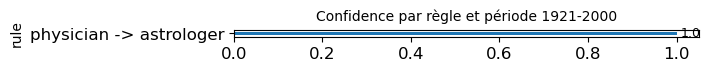

In [ ]:
# loop through tickers and axes

# metric
#mt = 'lift'
mt = 'confidence'
#mt = 'zhangs_metric'

for ticker in tickers:
    
   
    dd = df_p[(df_p['periodes']==ticker) & (df_p['length_l_occ']> 1) \
                         & (df_p.apply(lambda x: filter_occupation(x, lpf), axis=1))]
    te = TransactionEncoder()
    ## on cherche les combinaisons, on exclut donc les trois disciplines seules
    te_ary = te.fit_transform(dd['l_occupations'])
    data_df=pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(data_df, min_support= 0.009, use_colnames=True)
    
    ar = association_rules(frequent_itemsets, min_threshold=0.0 \
                 ).drop('conviction', axis=1).reset_index(drop=True)
    cc = ar.sort_values(by=mt, ascending=False)
    cc['rule'] = cc.apply(lambda x : ','.join(list(x['antecedents'])) + ' -> '+ ','.join(list(x['consequents'])), axis=1 )

    filtered_cc = cc[cc.apply(lambda x: filter_antecedents(x, lpa), axis=1)].head(20)
    print(len(filtered_cc))

    df = filtered_cc[['rule', mt]].sort_values(by=mt, ascending=False)

    if len(df) > 0:
        if len(df) == 20:
            fh = 8
        else: 
            fh = 0.1*len(df)
        ax=df.sort_values(by=mt, ascending=True).plot(x='rule', y=mt, 
                        kind='barh', fontsize=12, figsize=(6,fh)) # ,rot=5


        x = df.sort_values(by=mt, ascending=True)[mt].to_list()
        for i, v in enumerate(x):
            ax.text(v + 0.01, i, str(round(v,2)), color='black', fontsize=9, verticalalignment='center')  

        # chart formatting
        ax.set_title(ticker.upper(), fontsize=10)
        ax.get_legend().remove()
        ax.set_xlabel("")


        #plt.ylabel('Effectif')
        #plt.xlabel('Professions')
        plt.title('Confidence par règle et période ' + ticker, fontsize=10 )
    
    else:
        ax=ax


    
    
plt.show()
